In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from ltn_imp.automation.knowledge_base import KnowledgeBase


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Find the Best Hyperparameters

In [ ]:
seed = 10
state = 250

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
dataset = pd.read_csv("datasets/pima_indians_imputed.csv", index_col = 0)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [ ]:
initilize_models = False

In [ ]:
if initilize_models:
    # Define the models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=state),
        'GradientBoosting': GradientBoostingClassifier(random_state=state),
        'LogisticRegression': LogisticRegression(random_state=state, max_iter=1000),
        'RandomForest': RandomForestClassifier(random_state=state),
        'KNearestNeighbor': KNeighborsClassifier()
    }

    # Define parameter grids for each model
    param_grids = {
        'DecisionTree': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [5, 10]
        },
        'GradientBoosting': {
            'n_estimators': np.linspace(50, 250, 5).astype(int),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        },
        'LogisticRegression': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'RandomForest': {
            'n_estimators': np.linspace(50, 250, 5).astype(int),
            #'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [5, 10]
        },
        'KNearestNeighbor': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }

    scorer = make_scorer(recall_score)

    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        
        best_recall = 0
        best_model = None
        
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            clf = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring=scorer, refit='recall', cv=inner_cv, n_jobs=-1)
            clf.fit(X_train, y_train)
            
            current_recall = recall_score(y_test, clf.predict(X_test))
            if current_recall > best_recall:
                best_recall = current_recall
                best_model = clf.best_estimator_
        
        # Save the best model using pickle if it's better than what was previously found
        if best_model is not None:
            with open(f'models/{model_name}_best_model.pkl', 'wb') as f:
                pickle.dump(best_model, f)
            print(f"Best model for {model_name} saved with recall score of {best_recall:.4f}")
            print()

In [ ]:
import torch.nn as nn
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_hidden_layers, dropout_rate=0.5):
        super(MLPClassifier, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_dim))
        self.layers.append(nn.BatchNorm1d(hidden_dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))

        # Output layer with Sigmoid activation for binary classification
        self.layers.append(nn.Linear(hidden_dim, output_size))
        self.layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)


In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt import STATUS_OK, STATUS_FAIL
import torch

kb = KnowledgeBase("with_logic.yaml")

space = {
    'num_hidden_layers': hp.choice('num_hidden_layers', [1, 2, 3, 4]),
    'hidden_dim': hp.choice('hidden_dim', [32, 64, 128, 256, 512]),
    'learning_rate': hp.loguniform('learning_rate', -5, -3),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5),
    'epochs': hp.choice('epochs', [10, 20, 30, 50, 100]),
    'early_stopping': hp.choice('early_stopping', [True, False]),
    'patience': hp.choice('patience', [3, 5, 7, 10])
}

def objective(params):
    # Model initialization
    model = MLPClassifier(
        input_size=X.shape[1], 
        hidden_dim=int(params['hidden_dim']), 
        output_size=1, 
        num_hidden_layers=int(params['num_hidden_layers']),
        dropout_rate=params['dropout_rate']
    )    
    kb.predicates["Diabetic"] = model
    kb.set_converter()
    kb.set_rules()
    kb.set_rule_to_data_loader_mapping()
    kb.optimize(num_epochs=params['epochs'], early_stopping=params['early_stopping'], patience=params['patience'], lr=params['learning_rate'], verbose=False)    
    val_loss = kb.compute_validation_loss()
    return {'loss': val_loss, 'status': STATUS_OK}

if initilize_models:
    
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    print("Best hyperparameters found: ", best)

In [ ]:
epochs = 20
early_stopping = True
learning_rate = 0.03225475120014418
patience = 3

# Train and Evaluate Models

In [ ]:
device = torch.device("cpu")

def predict(model, x):
    try:
        model.eval()  # Ensure the model is in evaluation mode
    except:
        ""

    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()

        try:
            probs = model(x)
        except Exception as e:
            x = x.to(torch.device("cpu"))
            probs = torch.tensor(model.predict(x))

        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_metrics(model, data_loader):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

In [ ]:
saved_models = []

for file_name in os.listdir("models"):
    if file_name.endswith('.pkl'):
        file_path = os.path.join("models", file_name)
        with open(file_path, 'rb') as file:
            trained_model = pickle.load(file)
            model_class = trained_model.__class__
            model_params = trained_model.get_params()
            new_model = model_class(**model_params)
            saved_models.append(new_model)

In [12]:
seeds = [random.randint(0, 2000) for _ in range(30)]

train_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])
test_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])

test_data = pd.read_csv('datasets/pima_indians_imputed.csv', index_col=0).astype(float)
y = test_data.iloc[:, -1]

for seed in seeds:
    x_train, x_test = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=y)
    x_train.to_csv('datasets/train.csv')
    x_test.to_csv('datasets/test.csv')
    x_train, y_train = x_train.iloc[:, :-1], x_train.iloc[:, -1]
    x_test, y_test = x_test.iloc[:, :-1], x_test.iloc[:, -1]

    models = saved_models.copy()

    kb = KnowledgeBase("with_logic.yaml", device="cpu")
    kb_2 = KnowledgeBase("without_logic.yaml", device="cpu")

    models.append(kb.predicates["Diabetic"])
    models.append(kb_2.predicates["Diabetic"])

    X = kb.loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
    Y = kb.loaders[0].loader.dataset.data['Outcome']

    temp = True
    for model in models:
        model_name = model.__class__.__name__

        if model_name == "Sequential":
            model_name = "SKI MLP" if temp else "Regular MLP"
            temp = False

        if model_name not in test_df.index:
            test_df.loc[model_name] = [[], [], [], [], [], []] 
            train_df.loc[model_name] = [[], [], [], [], [], []]

        if hasattr(model, "fit"):
            model.fit(X, Y)
        elif model_name == "SKI MLP":
            kb.optimize(num_epochs=epochs, log_steps=100, lr=learning_rate, early_stopping=early_stopping, patience=patience, verbose=False)
            model = kb.predicates["Diabetic"]
        else:
            kb.optimize(num_epochs=epochs, log_steps=100, lr=learning_rate, early_stopping=early_stopping, patience=patience, verbose=False)
            model = kb_2.predicates["Diabetic"]

        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.loaders[0])
        train_df.loc[model_name, "Accuracy"].append(accuracy)
        train_df.loc[model_name, "Precision"].append(precision)
        train_df.loc[model_name, "Recall"].append(recall)
        train_df.loc[model_name, "F1 Score"].append(f1)
        train_df.loc[model_name, "Balanced Accuracy"].append(balanced_accuracy)
        train_df.loc[model_name, "MCC"].append(mcc)

        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
        test_df.loc[model_name, "Accuracy"].append(accuracy)
        test_df.loc[model_name, "Precision"].append(precision)
        test_df.loc[model_name, "Recall"].append(recall)
        test_df.loc[model_name, "F1 Score"].append(f1)
        test_df.loc[model_name, "Balanced Accuracy"].append(balanced_accuracy)
        test_df.loc[model_name, "MCC"].append(mcc)        

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


In [13]:
def plot_metrics(metrics_df):
    metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]
    plt.figure(figsize=(15, 25))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(6, 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

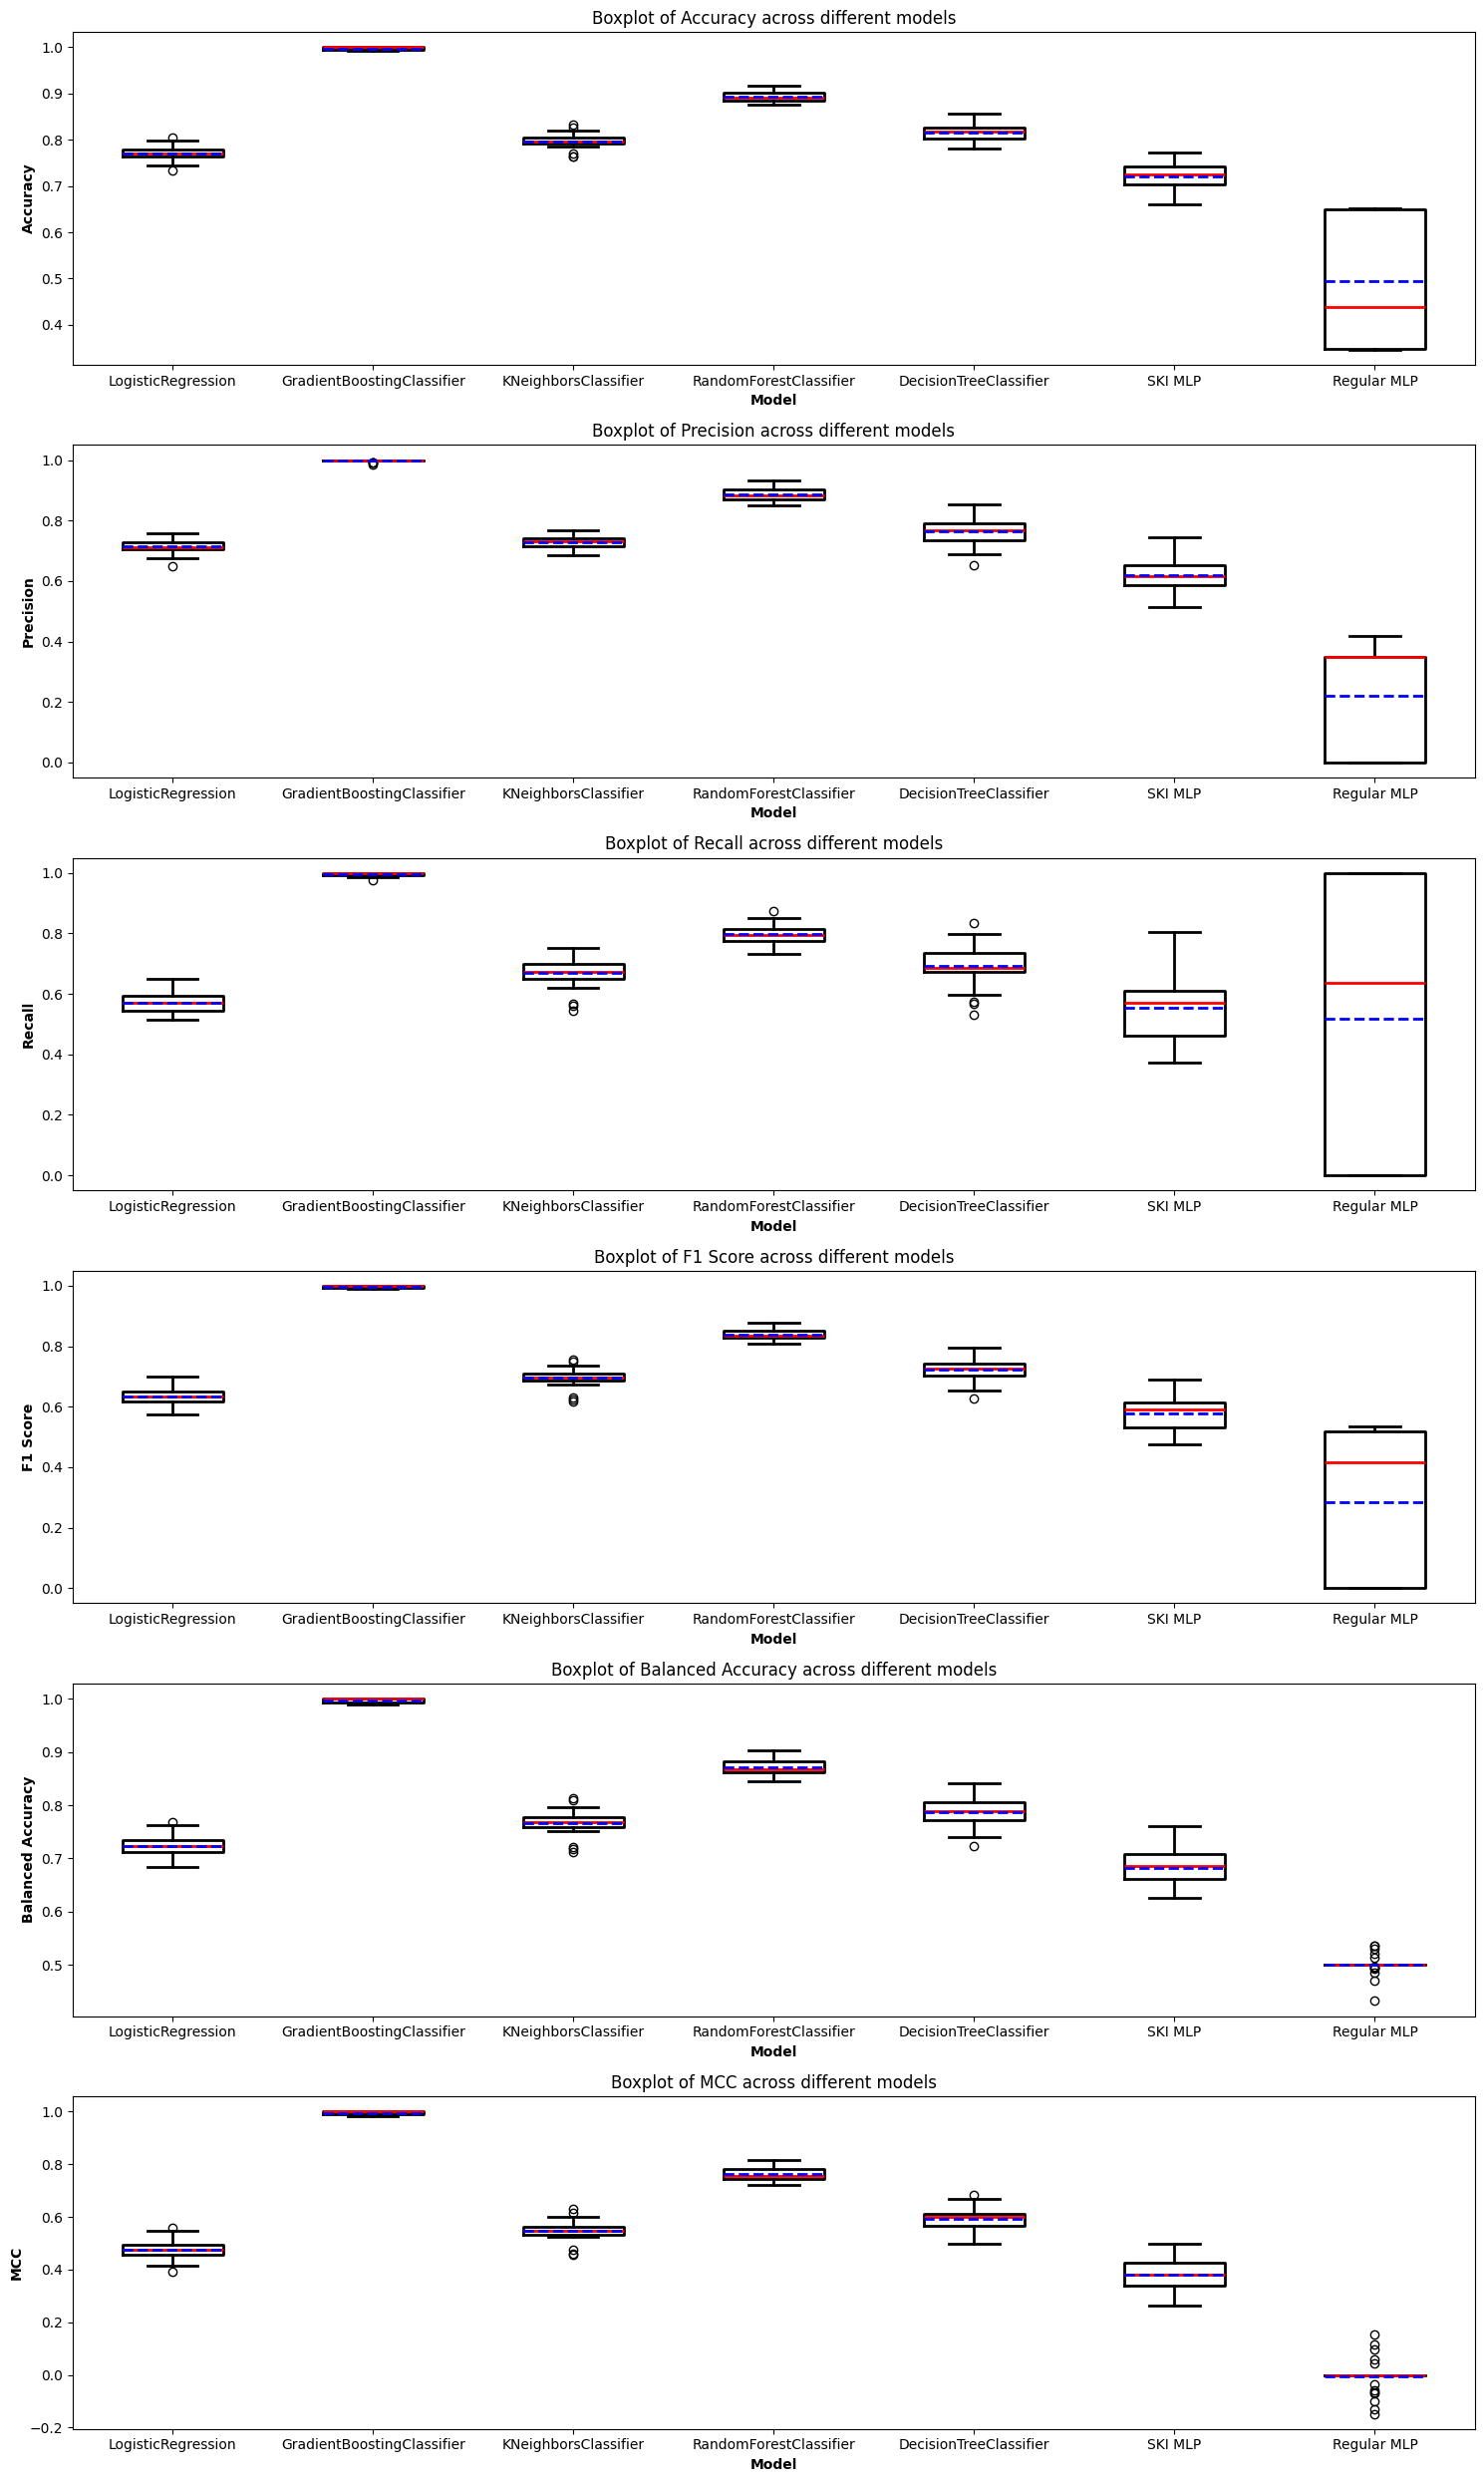

In [14]:
plot_metrics(train_df)

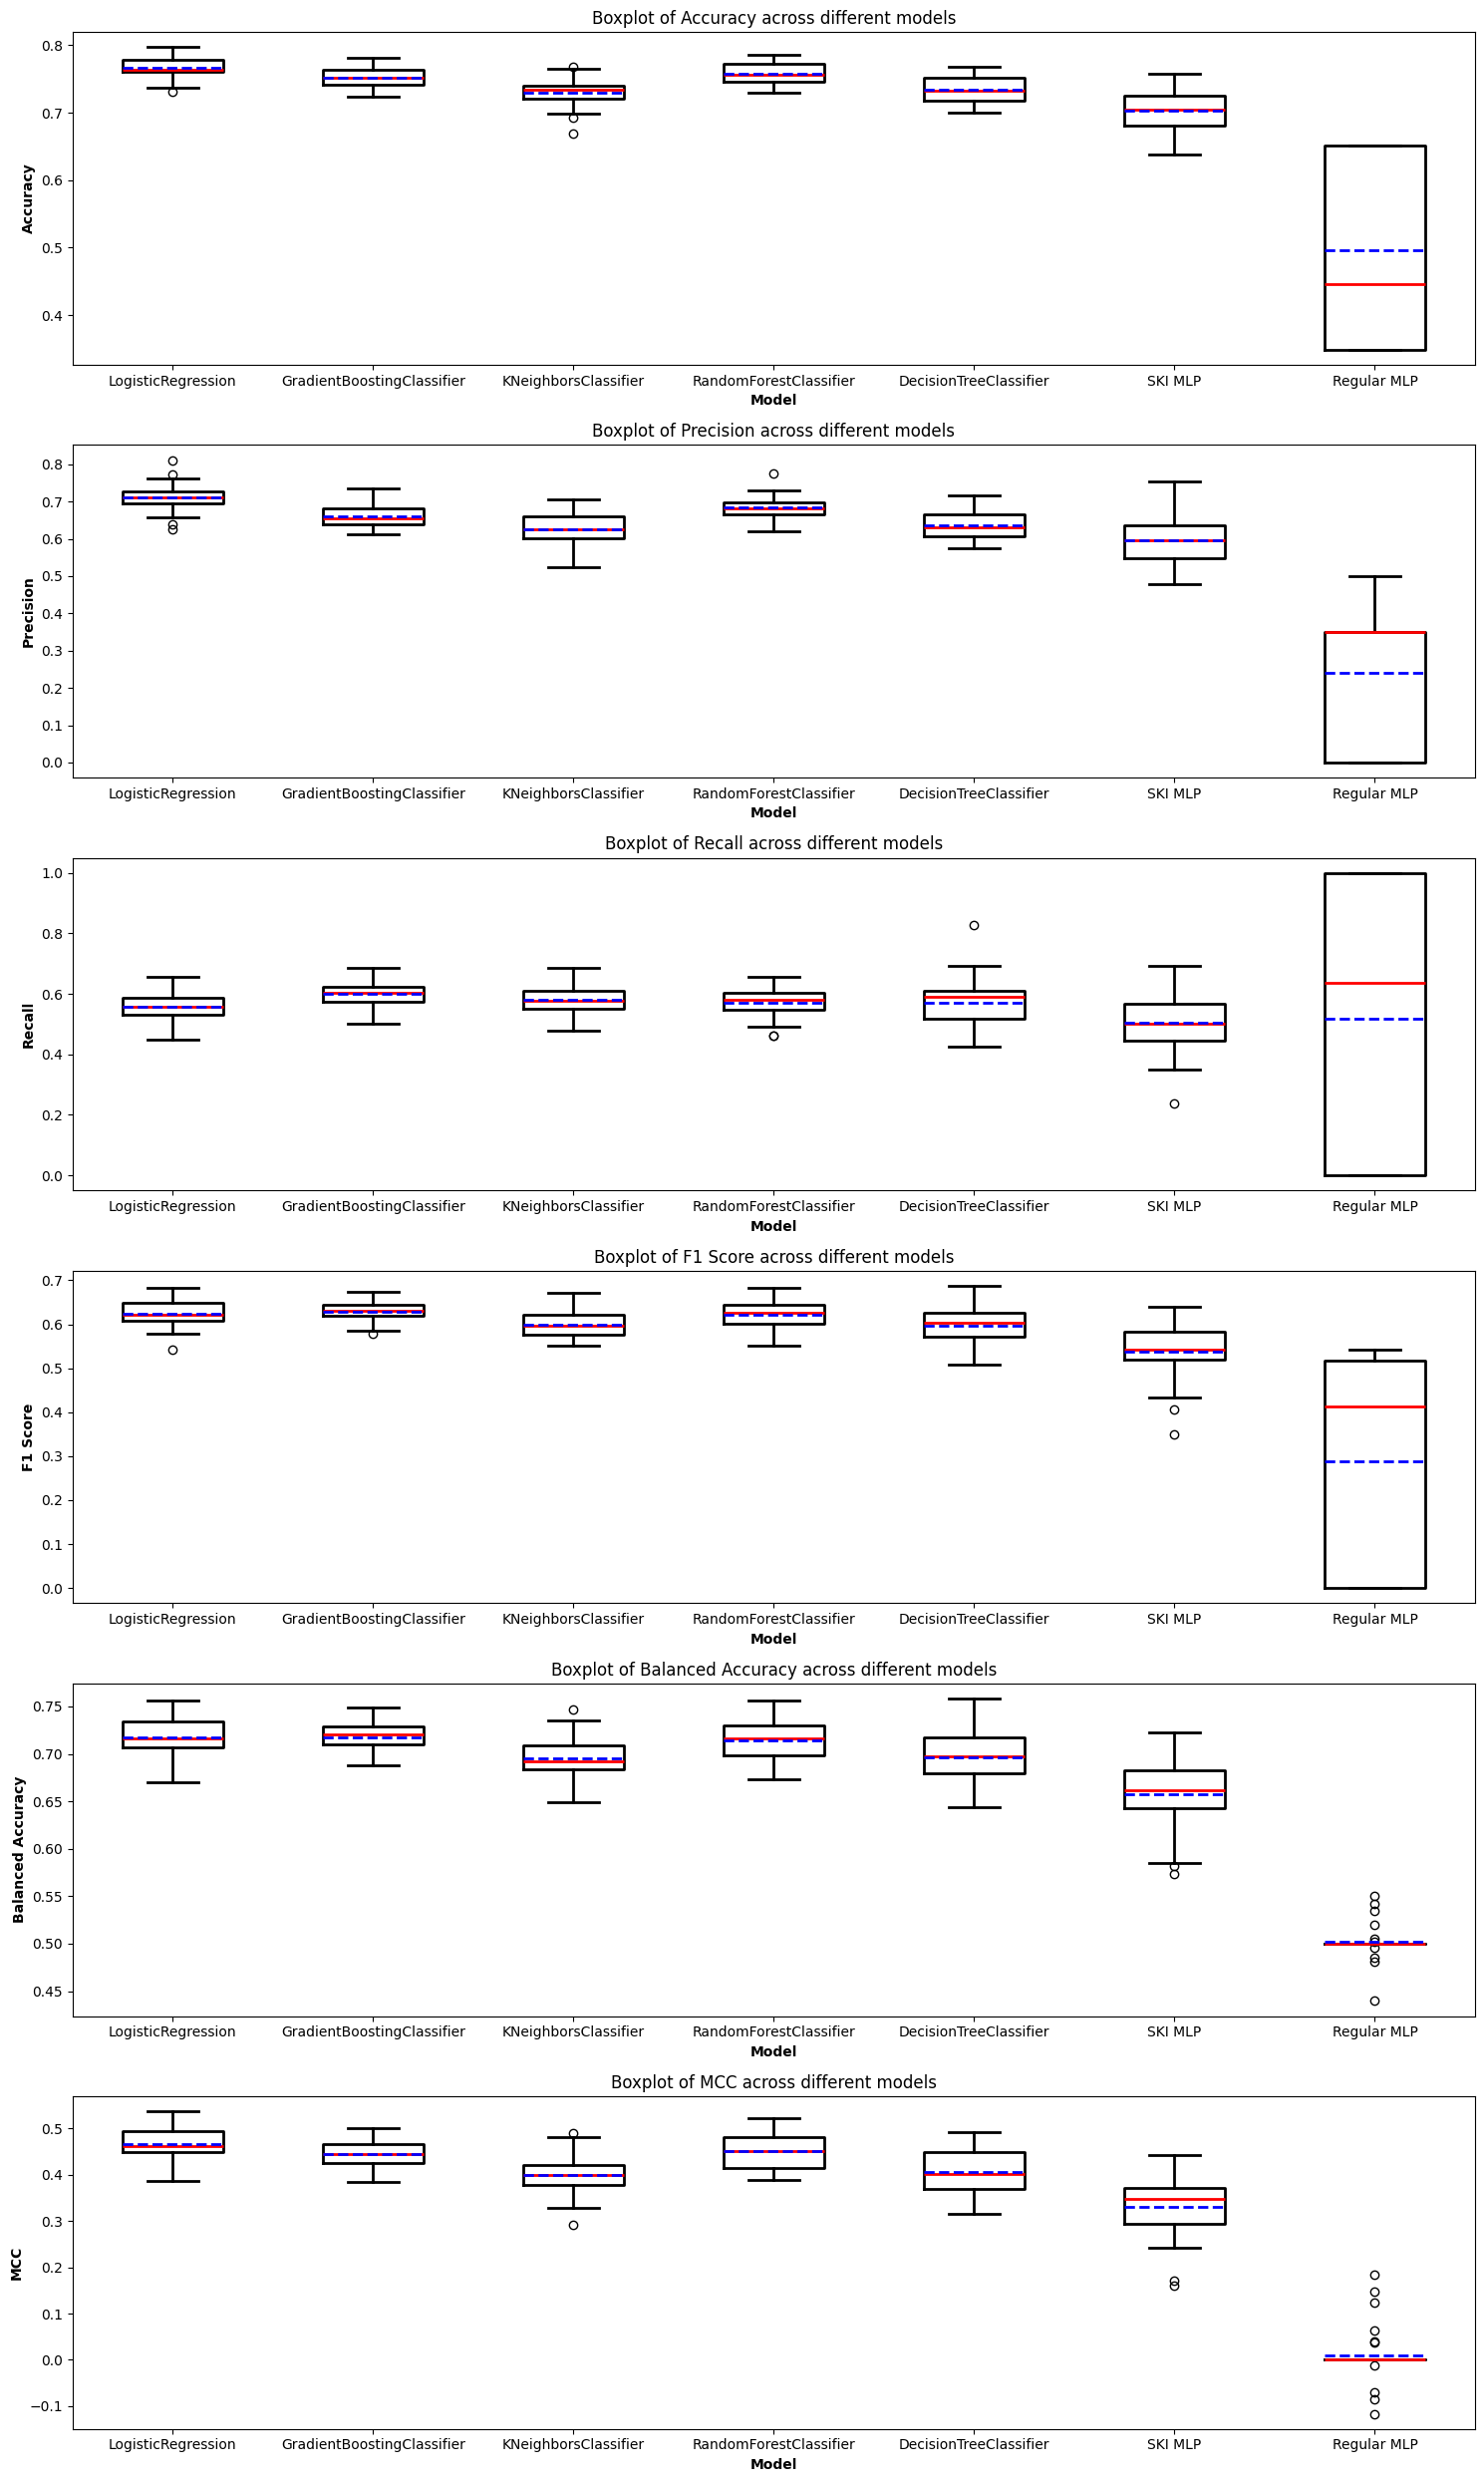

In [15]:
plot_metrics(test_df)

In [16]:
import scipy.stats as stats

def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        mean_scores = metrics_df[metric].apply(np.mean)
        best_model = mean_scores.idxmax()  
        best_models[metric] = best_model

    results = {}
    for metric in metrics_df.columns:
        best_model = best_models[metric]
        best_scores = metrics_df.loc[best_model, metric]
        
        results[metric] = {}
        
        for model_name in metrics_df.index:
            if model_name == best_model:
                continue
            
            comparison_scores = metrics_df.loc[model_name, metric]
            t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
            results[metric][model_name] = p_value 

    significance_level = 0.05
    for metric, comparisons in results.items():
        print(f"\n{metric}:")
        best_model = best_models[metric]
        for model_name, p_value in comparisons.items():
            if p_value < significance_level:
                print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
            else:
                print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")

In [17]:
compare_models(test_df)


Accuracy:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0004)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0085)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0.0000)

Precision:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0004)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0

In [18]:
import scipy.stats as stats

def perform_t_tests(metrics_df):

    results = {}

    for metric in metrics_df.columns:
        # Retrieve the scores for SKI MLP and Regular MLP
        ski_mlp_scores = metrics_df.loc['SKI MLP', metric]
        regular_mlp_scores = metrics_df.loc['Regular MLP', metric]
        
        # Perform a paired t-test between SKI MLP and Regular MLP
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        results[metric] = p_value 

    # Significance level for the tests
    significance_level = 0.05

    for metric, p_value in results.items():
        print(f"\n{metric}:")
        if p_value < significance_level:
            print(f"  SKI MLP is significantly better than Regular MLP (p = {p_value:.4f})")
        else:
            print(f"  SKI MLP is NOT significantly better than Regular MLP (p = {p_value:.4f})")

In [19]:
perform_t_tests(test_df)


Accuracy:
  SKI MLP is significantly better than Regular MLP (p = 0.0000)

Precision:
  SKI MLP is significantly better than Regular MLP (p = 0.0000)

Recall:
  SKI MLP is NOT significantly better than Regular MLP (p = 0.8791)

F1 Score:
  SKI MLP is significantly better than Regular MLP (p = 0.0000)

Balanced Accuracy:
  SKI MLP is significantly better than Regular MLP (p = 0.0000)

MCC:
  SKI MLP is significantly better than Regular MLP (p = 0.0000)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import LinearSegmentedColormap

In [21]:
def plot_model_comparison_heatmap(x_test, y_test, models, model_names):
    # Assuming models are already trained and have a .predict method
    results = {
        'Outcome': y_test.astype(int)
    }
    
    for model, name in zip(models, model_names):
        try:
            results[name] = model.predict(x_test).astype(int)
        except:
            x_test_ = torch.tensor(x_test.values, dtype=torch.float32)
            results[name] = [ int(x[0]) for x in predict(model, x_test_.squeeze()).numpy() ]

    res_df = pd.DataFrame(results)
    res_df = res_df.sort_values(by=list(res_df.columns), ascending=[False] * len(res_df.columns))
    res_df = res_df.reset_index(drop=True)
    res_df = res_df.astype(int)

    cmap = LinearSegmentedColormap.from_list('rg', ["lightseagreen", "silver", "gold"], N=256)

    plt.rcParams['patch.edgecolor'] = 'black'

    fig, axes = plt.subplots(figsize=(10, 5))

    sns.heatmap(res_df.T, cmap=cmap, cbar=False, alpha=0.4, xticklabels=100, linewidths=0.1, ax=axes, vmin=0, vmax=1)

    axes.set_yticklabels(['Outcome','LogisticRegression', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'RandomForestClassifier','DecisionTreeClassifier', 'SKI MLP', 'Regular MLP'])
    axes.tick_params(axis='both', which='major', labelsize=11)
    colors = axes.collections[0].get_facecolors()
    axes.collections[0].set_edgecolors(colors)


    legend_elements = [
        Patch(facecolor="gold", edgecolor="black", label="Diabetic"),
        Patch(facecolor="lightseagreen", edgecolor="black", label="Healthy"),
        Patch(facecolor="silver", edgecolor="black", label="N/A"),
    ]

    legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=11)
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_facecolor('black')
    legend.get_frame().set_edgecolor('black')

    for spine in axes.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(5.5)

    legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=11)
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_facecolor('none')
    legend.get_frame().set_edgecolor('black')

    plt.subplots_adjust(hspace=0.2)
    plt.tight_layout()
    plt.show()

    return res_df

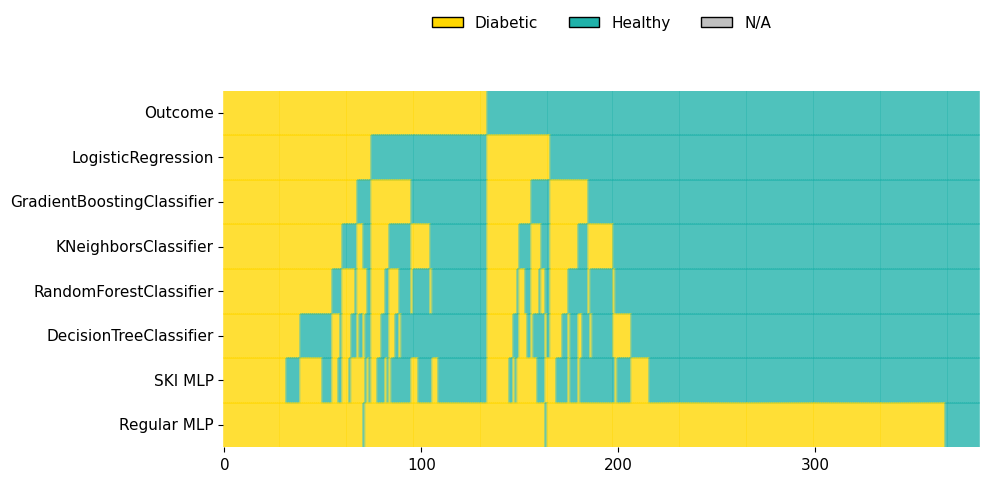

In [22]:
X_test = kb.test_loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
Y_test = kb.test_loaders[0].loader.dataset.data['Outcome']
res_df = plot_model_comparison_heatmap(X_test, Y_test, models, test_df.index)